## STP correlation with Tornadoes
##### Dr. Victor Gensini (Spring 2018)
##### Department of Geographic and Atmospheric Sciences
<img style="float:left;height:40px"src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQthtdrc2lZyEOC1iiwubFyvNfzJE7q7_GCTdlFF3peKckmi7cN">

In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy import ndimage
import scipy.stats
import matplotlib.font_manager as font_manager
from matplotlib import cm
from matplotlib.path import Path
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap, maskoceans
from scipy.stats.mstats import linregress
from scipy import stats
import shapefile
#import seaborn as sns
#sns.set()

In [2]:
raw_counts=[]
tor_days=[]
tor_file = '1950-2016_tor.csv'
tor_df = pd.read_csv(tor_file)
formats = '%Y-%m-%d'
tor_df['datei']=pd.to_datetime(tor_df['date'], format=formats)
tor_df=tor_df.set_index(pd.DatetimeIndex(tor_df['datei']))
years = np.arange(1979,2017,1)
for yr in years:
    #query='yr==%s & mag>=1' % yr
    query='yr==%s' % yr
    yr_tor = tor_df.query(query)
    #print(yr_tor['yr'].count(), yr_tor['date'].unique().size)
    raw_counts.append(yr_tor['yr'].count())
    tor_days.append(yr_tor['date'].unique().size)
#plt.plot(years,raw_counts)

(365, 39, 277, 349)


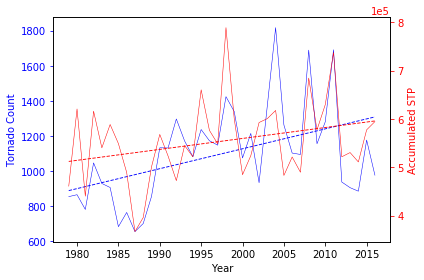

In [23]:
datadir = '/home/data/stp_narr/'
nc1 = Dataset('narr_latlon.nc','r',format='NETCDF4_CLASSIC')
lats = nc1.variables["lats"][0][:][:]
lons = nc1.variables["lons"][0][:][:]
nc1.close()


#read shapefile using pyshp (http://code.google.com/p/pyshp/)
sf = shapefile.Reader('/home/vgensini/projects/stp/shapefiles/US_outline.shp')
sfrec = sf.shapeRecord()
points = sfrec.shape.points
#print points
latty_bin = lats.flatten()
lonny_bin = lons.flatten()
lonlat = []

for lt,ln in zip(latty_bin,lonny_bin):
    lonlat.append([ln,lt])
#use points_inside_polygon to 
#clip = matplotlib.nxutils.points_inside_poly(lonlat,points)
path = Path(points)
clip = path.contains_points(lonlat)

#reshape array
clip = clip.reshape(lats.shape)

#read shapefile using pyshp (http://code.google.com/p/pyshp/)
sf = shapefile.Reader('/home/vgensini/projects/stp/shapefiles/mask.shp')
sfrec = sf.shapeRecord()
points = sfrec.shape.points
#print points
latty_bin = lats.flatten()
lonny_bin = lons.flatten()
lonlat = []

for lt,ln in zip(latty_bin,lonny_bin):
    lonlat.append([ln,lt])
#use points_inside_polygon to 
#clip = matplotlib.nxutils.points_inside_poly(lonlat,points)
path = Path(points)
clip1 = path.contains_points(lonlat)

#reshape array
clip1 = clip1.reshape(lats.shape)


stp_gt1_all=np.load(datadir+'narr_stp_diurnal_max_79_17.npy')
#stp_gt1_all=np.load(datadir+'stp_00z.npy')
print (stp_gt1_all.shape)
#stp_gt1_all = np.squeeze(stp_gt1_all)
inter_var = np.sum(stp_gt1_all,axis=0)
jul_vals =[]
doy = np.arange(0,365,1,dtype=np.int)
years = np.arange(0,38,1,dtype=np.int)
plt.figure(figsize=(18,11))
for yr in years:
    stp_dy_val = inter_var[yr,:,:]
    stp_dy_val_clip = np.ma.masked_where(clip==False,stp_dy_val)
    jul_vals.append(stp_dy_val_clip.sum()*3.)
plt.figure(figsize=(18,11))
#fit = np.polyfit(years,jul_vals,1)
#fit_fn = np.poly1d(fit) 
#fit1 = np.polyfit(years,raw_counts,1)
#fit_fn1 = np.poly1d(fit1) 
# fit_fn is now a function which takes in x and returns an estimate for y

#plt.plot(years,jul_vals, 'b-', years, fit_fn(years), '--k')
#plt.title('1979-2017 Interannual Variability of US Gridpoint Hours with STP > 1')
fig, ax1 = plt.subplots()
t = np.arange(1979,2017,1)
fit = np.polyfit(t,jul_vals,1)
fit_fn = np.poly1d(fit) 
fit1 = np.polyfit(t,raw_counts,1)
fit_fn1 = np.poly1d(fit1) 
ax1.set_xlabel('Year')
ax1.set_ylabel('Tornado Count',color='b')
ax1.tick_params(axis='y', colors='blue')
ax1.plot(t, raw_counts, 'b-', linewidth=0.5)
ax1.plot(t, fit_fn1(t), '--b', linewidth=0.9)
ax2 = ax1.twinx()
ax2.set_ylabel('Accumulated STP',color='r')
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.tick_params(axis='y', colors='red')
ax2.plot(t, jul_vals, 'r-', linewidth=0.5)
ax2.plot(t, fit_fn(t), '--r', linewidth=0.9)
plt.tight_layout()
plt.savefig('Figure1.png',dpi=200)
# for val in raw_counts:
#     print(val)
# for val in jul_vals:
#     print(val)

(0.66002283763138758, 6.5402456275436013e-06)


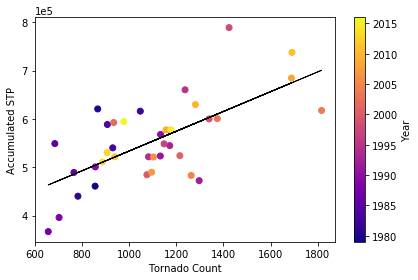

In [22]:
CS=plt.scatter(raw_counts,jul_vals,c=np.arange(1979,2017,1),cmap=cm.plasma)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
print(scipy.stats.pearsonr(raw_counts,jul_vals))
fit = np.polyfit(raw_counts,jul_vals,1)
fit_fn = np.poly1d(fit)
plt.plot(raw_counts,fit_fn(raw_counts), '-k', linewidth=0.9)
CS=plt.colorbar(label='Year')
plt.xlabel('Tornado Count')
plt.ylabel('Accumulated STP')
plt.tight_layout()
plt.savefig('Figure2.png',dpi=200)

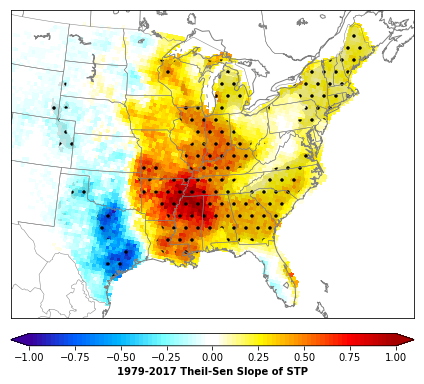

In [26]:
def theilsen(a,years):
    yr,y,x = a.shape
    slope = np.zeros((y,x))   
    intercept = np.zeros((y,x))   
    lo = np.zeros((y,x))
    up = np.zeros((y,x))   
    for yy in range(y):
        for xx in range(x):
            slope[yy,xx],intercept[yy,xx],lo[yy,xx],up[yy,xx] = stats.mstats.theilslopes(a[:,yy,xx],years)
    return slope

def kendalltau(a,years):
    yr,y,x = a.shape   
    tau = np.zeros((y,x))   
    pval = np.zeros((y,x))   
    for yy in range(y):
        for xx in range(x):
            tau[yy,xx],pval[yy,xx] = stats.kendalltau(years,a[:,yy,xx])#,years)
    #return (tau,pval)
    return pval

slope = theilsen(inter_var,np.arange(1979,2018,1))
pval = kendalltau(inter_var,np.arange(1979,2018,1))

#print (pval.shape)

#print (vals.shape)
fig = plt.figure()
fig.set_size_inches(6,6)
m = Basemap  (projection='lcc',lon_0=-92.54199,lat_0=38.09401,llcrnrlat=24, urcrnrlat=47,llcrnrlon=-106,urcrnrlon=-61,resolution='l',area_thresh=1000)
m.drawcoastlines(color='gray')
m.drawstates(color='gray')
#masked = maskoceans(lons,lats,slope)
masked = np.ma.masked_where(clip==False,slope)
#masked1 = maskoceans(lons,lats,pval)
masked1 = np.ma.masked_where(clip1==False,pval)
m.drawcountries(color='gray')
x,y = m(lons,lats)
temper_anom = ['#3c009c','#3609A5','#3013AF','#2A1CB9','#2426C3','#1E30CD','#1839D7','#1243E1','#0C4CEB','#0656F5','#0060FF','#0068FF','#0071FF','#0079FF','#0082FF','#008BFF','#0093FF','#009CFF','#00A4FF','#00ADFF','#00B6FF','#0CBDFF','#18C4FF','#24CBFF','#30D3FF','#3CDAFF','#48E1FF','#54E9FF','#60F0FF','#6CF7FF','#79FFFF','#86FFFF','#93FFFF','#A1FFFF','#AEFFFF','#BCFFFF','#C9FFFF','#D6FFFF','#E4FFFF','#F1FFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFEE5','#FFFDCC','#FFFCB2','#FFFB99','#FFFB7F','#FFFA66','#FFF94C','#FFF833','#FFF719','#FFF700','#FFEB00','#FFDF00','#FFD300','#FFC700','#FFBB00','#FFAF00','#FFA300','#FF9700','#FF8B00','#FF7F00','#FE7200','#FE6500','#FE5800','#FE4C00','#FE3F00','#FE3200','#FE2600','#FE1900','#FE0C00','#FE0000','#F50000','#EC0000','#E30000','#DA0000','#D20000','#C90000','#C00000','#B70000','#AE0000','#A60000']
cmap = matplotlib.colors.ListedColormap(temper_anom)
plot = m.pcolormesh(x,y,masked,zorder=1,vmin=-1, vmax=1,cmap=cmap)
colbar = m.colorbar(plot,"bottom", size="4%",pad="5%",extend='both')
colbar.set_label('1979-2017 Theil-Sen Slope of STP',fontsize='medium',weight='bold')
levs = [-0.05,0.05]
m.contourf(x,y,masked1,levs,cmap=None,colors='black',alpha=.1,hatches=['.'])
#levs1 = [-900,-1.96]
#m.contourf(x,y,sigdiff,levs1,color=None,hatch=['/'])
plt.tight_layout()
plt.savefig('Figure3.png',dpi=100)